<h2> Import Libraries</h2>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt   

from sklearn.model_selection import train_test_split   
from sklearn.preprocessing import LabelEncoder

import librosa 
import librosa.display

import tensorflow.keras as keras
from keras import layers, Sequential

import warnings
warnings.simplefilter('ignore')

2022-05-05 16:44:03.060763: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-05 16:44:03.060832: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [14]:
AUDIO_SIGNAL_PATH = 'pkl_files/audio.npy'
NOISED_SIGNAL_PATH = 'pkl_files/noised_signal.npy'
TARGET_PATH = 'pkl_files/target.csv'
MODEL_WEIGHTS_PATH = 'models/model_wieghts.hdf5'
MAPPING_PATH = 'pkl_files/mapping_file.npy'
MODEL1 = 'models/model1.h5'
AUGMENTED_MODEL = 'models/augmented_model.h5'
NOISE_RATE = 0.22
SECONDS = 1.0
AUGMENTED_DATA_SIZE = 14000

In [3]:
def build_model(input_shape):
    model = Sequential()
    
    # features extracting layers
    # conv 1 + maxpool
    model.add(keras.layers.Conv2D(3, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # conv 2 + maxpool
    model.add(keras.layers.Conv2D(3, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # conv 3 + maxpool
    model.add(keras.layers.Conv2D(3, (2, 2), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # Flatten layer + classification layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=128, activation='relu'))
    model.add(keras.layers.Dropout(rate=0.25))
    
    # output layer
    model.add(keras.layers.Dense(units=8, activation='softmax'))
    
    return model

In [4]:
def signal_mfcc_preprocessing(signals, N_MFCC=13):
    mfcc_array = []
    for signal in signals:
        mfcc = librosa.feature.mfcc(signal, n_mfcc=N_MFCC)
        mfcc_array.append(mfcc)
        
    mfcc_array = np.array(mfcc_array)
    mfcc_array = mfcc_array[..., np.newaxis]
    return mfcc_array

In [5]:
def add_white_noise(signal, noise_rate):
    white_noise = np.random.normal(0, 1, signal.size)
    noised_signal = signal + white_noise * noise_rate
    return noised_signal

In [6]:
def cm_normalize(cm, axis_size=8):
    cm = [cm[i, j] / sum(cm[i, :]) for i in range(axis_size) for j in range(axis_size)]
    cm = np.array(cm).reshape(axis_size, axis_size)
    return cm

<h2> Data augmentation </h2>

In [8]:
# read signal, target files

X_signal = np.load(AUDIO_SIGNAL_PATH, allow_pickle=True)
y = pd.read_csv(TARGET_PATH).values

In [11]:
# remove audios less than 1.0 sec
period = pd.Series(X_signal.reshape(-1)).apply(len) / 22050
X_signal = pd.Series(X_signal.reshape(-1)).drop(period[period<SECONDS].index)

# take only a apart of original data to add noise
X_signal = X_signal[:AUGMENTED_DATA_SIZE]
y = y[:AUGMENTED_DATA_SIZE]

# add noise to the original data

noised_signal = add_white_noise(X_signal, NOISE_RATE)

In [41]:
# save data in HDD
np.save(NOISED_SIGNAL_PATH, noised_signal, allow_pickle=True)

In [12]:
# tranform our noised signal in mfcc form
noised_mfcc = signal_mfcc_preprocessing(noised_signal, N_MFCC=13)

In [13]:
# encode y from string to integers
le = LabelEncoder()
y = le.fit_transform(y)

# split mfcc to train & validation data
X_train, X_test, y_train, y_test = train_test_split(noised_mfcc, y
                                                    ,test_size=0.2
                                                    ,shuffle=True
                                                    ,random_state=101)

<h2> Train model </h2>

In [49]:
model = build_model(noised_mfcc.shape[1:])
model.load_weights(MODEL_WEIGHTS_PATH) # load weights of trained model without data augmentation

model.summary()

2022-04-24 00:29:17.267017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 00:29:17.267537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-24 00:29:17.267637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-24 00:29:17.267723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-24 00:29:17.267805: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [52]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer
             ,loss='sparse_categorical_crossentropy'
             ,metrics=['accuracy'])

es = keras.callbacks.EarlyStopping(min_delta=0.01, patience=20, restore_best_weights=True)

In [93]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32
                   ,callbacks=[es])

Epoch 1/100
350/350 [==============================] - 3s 8ms/step - loss: 0.6434 - accuracy: 0.7771 - val_loss: 0.5989 - val_accuracy: 0.7982
Epoch 2/100
350/350 [==============================] - 3s 8ms/step - loss: 0.6384 - accuracy: 0.7774 - val_loss: 0.5999 - val_accuracy: 0.7968
Epoch 3/100
350/350 [==============================] - 3s 7ms/step - loss: 0.6315 - accuracy: 0.7821 - val_loss: 0.6024 - val_accuracy: 0.8011
Epoch 4/100
350/350 [==============================] - 3s 7ms/step - loss: 0.6194 - accuracy: 0.7861 - val_loss: 0.5973 - val_accuracy: 0.7996
Epoch 5/100
350/350 [==============================] - 3s 7ms/step - loss: 0.6153 - accuracy: 0.7894 - val_loss: 0.5970 - val_accuracy: 0.8025
Epoch 6/100
350/350 [==============================] - 3s 7ms/step - loss: 0.6214 - accuracy: 0.7860 - val_loss: 0.6044 - val_accuracy: 0.7982
Epoch 7/100
350/350 [==============================] - 2s 7ms/step - loss: 0.6099 - accuracy: 0.7856 - val_loss: 0.6014 - val_accuracy: 0.8029

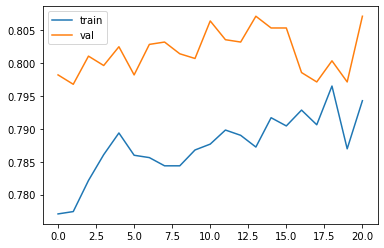

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='val')
axs[0].set_title('loss')
axs[0].legend()


axs[1].plot(history.history['accuracy'], label='train')
axs[1].plot(history.history['val_accuracy'], label='val')
axs[1].set_title('accuracy')
axs[1].legend()

plt.show()

In [11]:
# save model with augmentation
# model.save_weights('model_wieghts.hdf5', over_write=True)

# model.save('augmented_model.h5')

<h2> Evaluate augmented model metrics</h2>

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
# test on noised data

RANGE = np.arange(0, 10000)

X_test = noised_signal[RANGE]
y_test = y[RANGE]

X_mfcc_test = signal_mfcc_preprocessing(X_test, N_MFCC=13)

ValueError: y contains previously unseen labels: [0, 1, 2, 3, 4, 5, 6, 7]

In [27]:
y_test.shape

(10000,)

2022-05-05 17:01:07.314795: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 22880000 exceeds 10% of free system memory.


<AxesSubplot:>

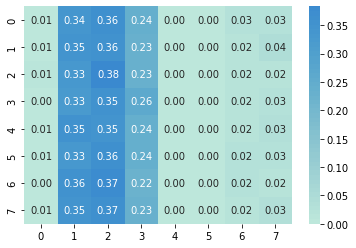

In [36]:
y_pred = model.predict(X_mfcc_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)
cm = cm_normalize(cm)

import seaborn as sns
sns.heatmap(cm, annot=True, center=True, fmt='.2f')

In [37]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.12      0.01      0.01      1277
           1       0.13      0.35      0.19      1261
           2       0.13      0.38      0.20      1255
           3       0.13      0.26      0.18      1197
           4       0.00      0.00      0.00      1266
           5       0.50      0.00      0.00      1238
           6       0.13      0.02      0.04      1251
           7       0.13      0.03      0.05      1255

    accuracy                           0.13     10000
   macro avg       0.16      0.13      0.08     10000
weighted avg       0.16      0.13      0.08     10000



<h2> Compare between two models </h2>

In [38]:
model1 = keras.models.load_model(MODEL1)

2022-05-05 17:05:38.550885: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 22880000 exceeds 10% of free system memory.


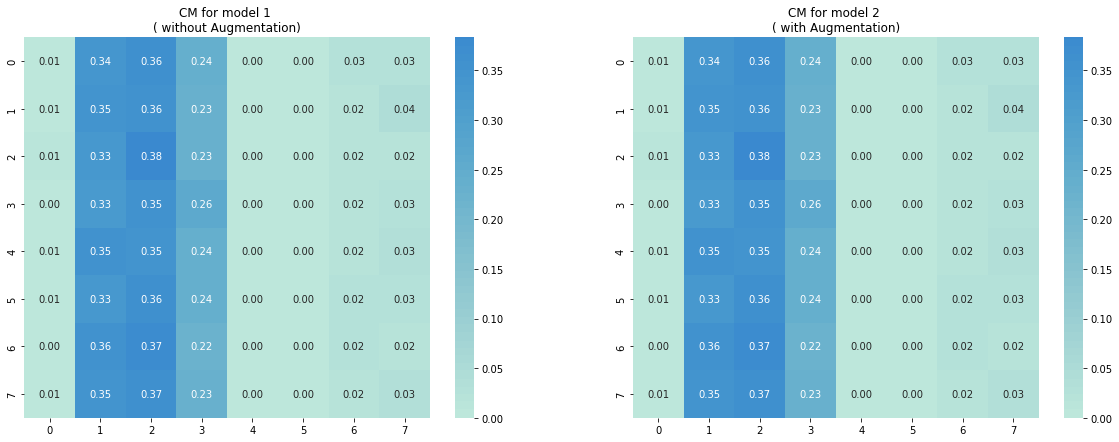

In [44]:
y_pred1 = model.predict(X_mfcc_test)
y_pred1 = np.argmax(y_pred1, axis=1)
cm1 = confusion_matrix(y_test, y_pred1)
cm1 = cm_normalize(cm1)

fig, axs = plt.subplots(1, 2, figsize=(20, 7))

sns.heatmap(cm1, annot=True, center=True, fmt='.2f', ax=axs[0])
sns.heatmap(cm, annot=True, center=True, fmt='.2f', ax=axs[1])
axs[0].set_title('CM for model 1 \n( without Augmentation)')
axs[1].set_title('CM for model 2 \n( with Augmentation)')

plt.show()

In [48]:
from termcolor import colored
print(colored('Classification report for model 1\nwithout augmentation', 'red'))
print(classification_report(y_test, y_pred1))
print(colored(70*'#', 'blue'))
print(colored('Classification report for model 2\nwith augmentation', 'red'))
print(classification_report(y_test, y_pred))

Classification report for model 1
without augmentation
              precision    recall  f1-score   support

           0       0.12      0.01      0.01      1277
           1       0.13      0.35      0.19      1261
           2       0.13      0.38      0.20      1255
           3       0.13      0.26      0.18      1197
           4       0.00      0.00      0.00      1266
           5       0.50      0.00      0.00      1238
           6       0.13      0.02      0.04      1251
           7       0.13      0.03      0.05      1255

    accuracy                           0.13     10000
   macro avg       0.16      0.13      0.08     10000
weighted avg       0.16      0.13      0.08     10000

######################################################################
Classification report for model 2
with augmentation
              precision    recall  f1-score   support

           0       0.12      0.01      0.01      1277
           1       0.13      0.35      0.19      1261
        